# Notebook Overview: CNN-DINOv2 Hybrid

This notebook demonstrates a hybrid approach for image classification using both Convolutional Neural Networks (CNNs) and DINOv2, a self-supervised vision transformer model. The workflow includes:

- **Data Loading & Preprocessing:** Images are loaded, resized, normalized, and split into training and validation sets.
- **Feature Extraction:** DINOv2 is used to extract high-level features from images, leveraging its transformer-based architecture for robust representations.
- **CNN Model Construction:** A custom CNN is built to process image data, learning spatial hierarchies and patterns.
- **Hybrid Model Integration:** Features from DINOv2 and the CNN are combined, either by concatenation or other fusion techniques, to enhance classification performance.
- **Training & Evaluation:** The hybrid model is trained on the dataset, with metrics such as accuracy and loss tracked. Validation is performed to assess generalization.
- **Visualization & Analysis:** Results, including confusion matrices and sample predictions, are visualized to interpret model behavior.

This approach aims to leverage the strengths of both CNNs (local feature learning) and DINOv2 (global, context-aware representations) for improved image classification results.

#  Step 1: Model Setup, Dataset Preparation, and Validation Scoring

In [1]:
import os, cv2, json, math, random, torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from transformers import AutoImageProcessor, AutoModel

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # This forces CUDA to use deterministic algorithms (slower but consistent)
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR  = "/kaggle/input/recodai-luc-scientific-image-forgery-detection"
AUTH_DIR  = f"{BASE_DIR}/train_images/authentic"
FORG_DIR  = f"{BASE_DIR}/train_images/forged"
MASK_DIR  = f"{BASE_DIR}/train_masks"
TEST_DIR  = f"{BASE_DIR}/test_images"
DINO_PATH = "/kaggle/input/dinov2/pytorch/base/1"

IMG_SIZE = 518
BATCH_SIZE = 2
# MODEL_LOC = '/kaggle/input/cnndinov2-pbd/CNNDINOv2-U54/CNNDINOv2-U54/model_seg_final.pt'  # 0.310
# MODEL_LOC = '/kaggle/input/cnndinov2-pbd/CNNDINOv2-U52/CNNDINOv2-U52/model_seg_final.pt'  # 0.321
MODEL_LOC = '/kaggle/input/cnndinov2-pbd/CNNDINOv2-U52/CNNDINOv2-U52/model_seg_final.pt'  # 0.321

# INFERENCE UTILS
AREA_THR = 190
MEAN_THR = 0.21
USE_TTA = False
GRID_SEARCH = False

class ForgerySegDataset(Dataset):
    def __init__(self, auth_paths, forg_paths, mask_dir, img_size=IMG_SIZE):
        self.samples = []
        for p in forg_paths:
            m = os.path.join(mask_dir, Path(p).stem + ".npy")
            if os.path.exists(m):
                self.samples.append((p, m))
        for p in auth_paths:
            self.samples.append((p, None))
        self.img_size = img_size
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        if mask_path is None:
            mask = np.zeros((h, w), np.uint8)
        else:
            m = np.load(mask_path)
            if m.ndim == 3: m = np.max(m, axis=0)
            mask = (m > 0).astype(np.uint8)
        img_r = img.resize((IMG_SIZE, IMG_SIZE))
        mask_r = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        img_t = torch.from_numpy(np.array(img_r, np.float32)/255.).permute(2,0,1)
        mask_t = torch.from_numpy(mask_r[None, ...].astype(np.float32))
        return img_t, mask_t


#  MODEL (DINOv2 + Decoder)

from transformers import AutoImageProcessor, AutoModel
processor = AutoImageProcessor.from_pretrained(DINO_PATH, local_files_only=True, use_fast=False)
encoder = AutoModel.from_pretrained(DINO_PATH, local_files_only=True).eval().to(device)

class DinoTinyDecoder(nn.Module):
    def __init__(self, in_ch=768, out_ch=1):
        super().__init__()
        # Block 1: 768 -> 384
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )
        # Block 2: 384 -> 192
        self.block2 = nn.Sequential(
            nn.Conv2d(384, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )
        # Block 3: 192 -> 96
        self.block3 = nn.Sequential(
            nn.Conv2d(192, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # Final Output: 96 -> 1
        self.conv_out = nn.Conv2d(96, out_ch, kernel_size=1)
    
    def forward(self, f, target_size):
        # f: [B, 768, 37, 37]
        
        # Step 1: Up to ~74x74
        x = F.interpolate(self.block1(f), size=(74, 74), mode='bilinear', align_corners=False)
        
        # Step 2: Up to ~148x148
        x = F.interpolate(self.block2(x), size=(148, 148), mode='bilinear', align_corners=False)
        
        # Step 3: Up to ~296x296
        x = F.interpolate(self.block3(x), size=(296, 296), mode='bilinear', align_corners=False)
        
        # Step 4: Final jump to 518x518
        x = self.conv_out(x)
        x = F.interpolate(x, size=target_size, mode='bilinear', align_corners=False)
        
        return x
    
class DinoSegmenter(nn.Module):
    def __init__(self, encoder, processor):
        super().__init__()
        self.encoder, self.processor = encoder, processor
        for p in self.encoder.parameters(): p.requires_grad = False
        self.seg_head = DinoTinyDecoder(768,1)
    def forward_features(self,x):
        imgs = (x*255).clamp(0,255).byte().permute(0,2,3,1).cpu().numpy()
        inputs = self.processor(images=list(imgs), return_tensors="pt").to(x.device)
        # with torch.no_grad(): 
        #     feats = self.encoder(**inputs).last_hidden_state
        feats = self.encoder(**inputs).last_hidden_state
        B,N,C = feats.shape
        fmap = feats[:,1:,:].permute(0,2,1)
        s = int(math.sqrt(N-1))
        fmap = fmap.reshape(B,C,s,s)
        return fmap
    def forward_seg(self,x):
        fmap = self.forward_features(x)
        return self.seg_head(fmap,(IMG_SIZE,IMG_SIZE))


auth_imgs = sorted([str(Path(AUTH_DIR)/f) for f in os.listdir(AUTH_DIR)])
forg_imgs = sorted([str(Path(FORG_DIR)/f) for f in os.listdir(FORG_DIR)])
train_auth, val_auth = train_test_split(auth_imgs, test_size=0.2, random_state=42)
train_forg, val_forg = train_test_split(forg_imgs, test_size=0.2, random_state=42)

train_loader = DataLoader(ForgerySegDataset(train_auth, train_forg, MASK_DIR),
                          batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(ForgerySegDataset(val_auth, val_forg, MASK_DIR),
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model_seg = DinoSegmenter(encoder, processor).to(device)

# Load pretrained weights if MODEL_LOC is specified
if MODEL_LOC is not None and os.path.exists(MODEL_LOC):
    model_seg.load_state_dict(torch.load(MODEL_LOC, map_location=device))
    print(f"✅ Loaded pretrained model from: {MODEL_LOC}")
    model_seg.eval()  # Set model to evaluation mode

@torch.no_grad()
def segment_prob_map(pil):
    x = torch.from_numpy(np.array(pil.resize((IMG_SIZE, IMG_SIZE)), np.float32)/255.).permute(2,0,1)[None].to(device)
    prob = torch.sigmoid(model_seg.forward_seg(x))[0,0].cpu().numpy()
    return prob

@torch.no_grad()
def segment_prob_map_with_tta(pil):
    # 1. Preprocessing: Resize, Normalize, and move to Device
    x = torch.from_numpy(np.array(pil.resize((IMG_SIZE, IMG_SIZE)), np.float32)/255.).permute(2,0,1)[None].to(device)
    
    predictions = []

    # 2. Original Prediction
    pred_orig = torch.sigmoid(model_seg.forward_seg(x))
    predictions.append(pred_orig)

    # 3. Horizontal Flip TTA (dim 3)
    # Flip input -> Predict -> Flip output back
    pred_h = torch.sigmoid(model_seg.forward_seg(torch.flip(x, dims=[3])))
    predictions.append(torch.flip(pred_h, dims=[3]))

    # 4. Vertical Flip TTA (dim 2)
    # Flip input -> Predict -> Flip output back
    pred_v = torch.sigmoid(model_seg.forward_seg(torch.flip(x, dims=[2])))
    predictions.append(torch.flip(pred_v, dims=[2]))

    # 5. Average the predictions and format as numpy
    # We stack the 3 predictions and take the mean across the stack dimension (0)
    prob = torch.stack(predictions).mean(0)[0, 0].cpu().numpy()

    return prob
    
def enhanced_adaptive_mask(prob, alpha_grad=0.45):
    gx = cv2.Sobel(prob, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(prob, cv2.CV_32F, 0, 1, ksize=3)
    grad_mag = np.sqrt(gx**2 + gy**2)
    grad_norm = grad_mag / (grad_mag.max() + 1e-6)
    enhanced = (1 - alpha_grad) * prob + alpha_grad * grad_norm
    enhanced = cv2.GaussianBlur(enhanced, (3,3), 0)
    thr = np.mean(enhanced) + 0.3 * np.std(enhanced)
    mask = (enhanced > thr).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    return mask, thr
    
# Replace your finalize_mask function with this:
def finalize_mask(prob, orig_size):
    # 1. Dynamic threshold calculation
    if prob.std() < 0.05:  # Low variance image
        thr = np.percentile(prob, 85)  # Conservative
    else:
        thr = np.mean(prob) + 0.25 * np.std(prob)  # Adjusted from 0.3
    
    # 2. Multi-scale morphological operations
    mask = (prob > thr).astype(np.uint8)
    area = mask.sum()
    
    # 3. Size-adaptive morphology
    if area > 0:
        kernel_size = max(3, min(7, int(np.sqrt(area)/50)))
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # 4. Resize to original
    mask = cv2.resize(mask, orig_size, interpolation=cv2.INTER_NEAREST)
    return mask, thr
    
# def finalize_mask(prob, orig_size):
#     mask, thr = enhanced_adaptive_mask(prob)
#     mask = cv2.resize(mask, orig_size, interpolation=cv2.INTER_NEAREST)
#     return mask, thr

def pipeline_final(pil):
    if USE_TTA:
        prob = segment_prob_map_with_tta(pil)
    else:
        prob = segment_prob_map(pil)
    mask, thr = finalize_mask(prob, pil.size)
    area = int(mask.sum())
    mean_inside = float(prob[cv2.resize(mask,(IMG_SIZE,IMG_SIZE),interpolation=cv2.INTER_NEAREST)==1].mean()) if area>0 else 0.0
    if area < AREA_THR or mean_inside < MEAN_THR:
        return "authentic", None, {"area": area, "mean_inside": mean_inside, "thr": thr}
    return "forged", mask, {"area": area, "mean_inside": mean_inside, "thr": thr}

import itertools
from sklearn.metrics import f1_score

def grid_search_area_mean(forg_paths, auth_paths, mask_dir):
    mean_range = [round(x, 2) for x in np.arange(0.20, 0.291, 0.01)]
    area_range = [200]
    # 1. Use ALL images from both paths to maximize robustness
    val_set = [(p, "forged") for p in forg_paths] + [(p, "authentic") for p in auth_paths]
    
    print(f"🚀 Step 1: Caching probability maps for ALL {len(val_set)} images...")
    cache = []
    for p, label in tqdm(val_set):
        pil = Image.open(p).convert("RGB")
        w, h = pil.size
        
        # Get raw probability map
        prob = segment_prob_map_with_tta(pil) if USE_TTA else segment_prob_map(pil)
        
        # USE OLD MASK LOGIC: mean + 0.3*std
        mask_raw, _ = enhanced_adaptive_mask(prob) # Your function using np.mean + 0.3*np.std
        mask_resized = cv2.resize(mask_raw, (w, h), interpolation=cv2.INTER_NEAREST)
        
        # Handle Ground Truth
        if label == "forged":
            m_gt = np.load(Path(mask_dir)/f"{Path(p).stem}.npy")
            if m_gt.ndim == 3: m_gt = np.max(m_gt, axis=0)
            m_gt = (m_gt > 0).astype(np.uint8)
        else:
            m_gt = np.zeros((h, w), np.uint8) # Authentic = blank GT
            
        cache.append({"prob": prob, "mask": mask_resized, "gt": m_gt, "label": label})

    # 2. Sweep thresholds
    best_f1 = -1
    best_params = {}
    combinations = list(itertools.product(area_range, mean_range))
    
    for a_thr, m_thr in combinations:
        current_f1s = []
        for item in cache:
            mask = item["mask"]
            area = int(mask.sum()) # OLD AREA LOGIC
            
            # OLD MEAN LOGIC
            mask_small = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            mean_in = float(item["prob"][mask_small == 1].mean()) if area > 0 else 0.0
            
            # Pipeline decision
            is_forged = (area >= a_thr and mean_in >= m_thr)
            m_pred = (mask > 0).astype(np.uint8) if is_forged else np.zeros_like(item["gt"])
            
            # F1 Calculation (Authentic silence = 1.0, noisy prediction = 0.0)
            f1 = f1_score(item["gt"].flatten(), m_pred.flatten(), 
                          zero_division=1 if item["label"] == "authentic" else 0)
            current_f1s.append(f1)
            
        avg_f1 = np.mean(current_f1s)
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_params = {"AREA_THR": a_thr, "MEAN_THR": m_thr}
            print(f"⭐ New Best F1: {best_f1:.4f} -> AREA: {a_thr}, MEAN: {m_thr}")

    return best_params

if GRID_SEARCH:
    best_cfg = grid_search_area_mean(val_forg, val_auth, MASK_DIR)
    AREA_THR = best_cfg['AREA_THR']
    MEAN_THR = best_cfg['MEAN_THR']


from sklearn.metrics import f1_score
val_items = [(p, 1) for p in val_forg[:10]]
results = []
for p,_ in tqdm(val_items, desc="Validation forged-only"):
    pil = Image.open(p).convert("RGB")
    label, m_pred, dbg = pipeline_final(pil)
    m_gt = np.load(Path(MASK_DIR)/f"{Path(p).stem}.npy")
    if m_gt.ndim==3: m_gt=np.max(m_gt,axis=0)
    m_gt=(m_gt>0).astype(np.uint8)
    m_pred=(m_pred>0).astype(np.uint8) if m_pred is not None else np.zeros_like(m_gt)
    f1 = f1_score(m_gt.flatten(), m_pred.flatten(), zero_division=0)
    results.append((Path(p).stem, f1, dbg))
print("\n F1-score par image falsifiée:\n")
for cid,f1,dbg in results:
    print(f"{cid} — F1={f1:.4f} | area={dbg['area']} mean={dbg['mean_inside']:.3f} thr={dbg['thr']:.3f}")
print(f"\n Moyenne F1 (falsifiées) = {np.mean([r[1] for r in results]):.4f}")

2026-01-08 14:14:49.768069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767881690.200615      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767881690.340631      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767881691.352458      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767881691.352506      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767881691.352508      24 computation_placer.cc:177] computation placer alr

✅ Loaded pretrained model from: /kaggle/input/cnndinov2-pbd/CNNDINOv2-U52/CNNDINOv2-U52/model_seg_final.pt


Validation forged-only: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


 F1-score par image falsifiée:

39341 — F1=0.5428 | area=8735 mean=0.548 thr=0.245
30587 — F1=0.0000 | area=295179 mean=0.013 thr=0.007
9849 — F1=0.0000 | area=1512074 mean=0.067 thr=0.016
57066 — F1=0.0000 | area=24380 mean=0.013 thr=0.006
2087 — F1=0.0000 | area=49525 mean=0.020 thr=0.014
28818 — F1=0.0000 | area=13384 mean=0.021 thr=0.007
42886 — F1=0.5164 | area=42841 mean=0.657 thr=0.309
41125 — F1=0.7830 | area=171390 mean=0.759 thr=0.305
13898 — F1=0.0000 | area=54425 mean=0.011 thr=0.005
26560 — F1=0.0000 | area=39017 mean=0.085 thr=0.036

 Moyenne F1 (falsifiées) = 0.1842


# Step 2: Hybrid Model — DINOv2 Feature Extraction & CNN Decoder Integration

Inference on Test Set: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]



✅ Saved submission file: submission.csv
  case_id annotation    area      mean       thr
0      45  authentic  528555  0.169231  0.058223
🟢 45.png: authentic | area=0 mean=0.169


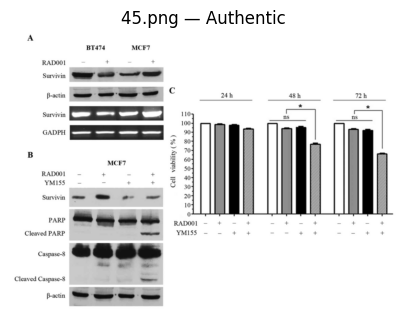

In [2]:
import os, json, cv2
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- RLE Encoder for Kaggle Submission ---
def rle_encode(mask: np.ndarray, fg_val: int = 1) -> str:
    pixels = mask.T.flatten()
    dots = np.where(pixels == fg_val)[0]
    if len(dots) == 0:
        return "authentic"
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return json.dumps([int(x) for x in run_lengths])

# --- Paths ---
TEST_DIR = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/test_images"
SAMPLE_SUB = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/sample_submission.csv"
OUT_PATH = "submission.csv"

rows = []
for f in tqdm(sorted(os.listdir(TEST_DIR)), desc="Inference on Test Set"):
    pil = Image.open(Path(TEST_DIR)/f).convert("RGB")
    label, mask, dbg = pipeline_final(pil)  # utilise la version améliorée

    # Sécurisation masque
    if mask is None:
        mask = np.zeros(pil.size[::-1], np.uint8)
    else:
        mask = np.array(mask, dtype=np.uint8)

    # Annotation finale
    if label == "authentic":
        annot = "authentic"
    else:
        annot = rle_encode((mask > 0).astype(np.uint8))

    rows.append({
        "case_id": Path(f).stem,
        "annotation": annot,
        "area": int(dbg.get("area", mask.sum())),
        "mean": float(dbg.get("mean_inside", 0.0)),
        "thr": float(dbg.get("thr", 0.0))
    })


sub = pd.DataFrame(rows)
ss = pd.read_csv(SAMPLE_SUB)
ss["case_id"] = ss["case_id"].astype(str)
sub["case_id"] = sub["case_id"].astype(str)
final = ss[["case_id"]].merge(sub, on="case_id", how="left")
final["annotation"] = final["annotation"].fillna("authentic")
final[["case_id", "annotation"]].to_csv(OUT_PATH, index=False)

print(f"\n✅ Saved submission file: {OUT_PATH}")
print(final.head(10))


sample_files = sorted(os.listdir(TEST_DIR))[:5]
for f in sample_files:
    pil = Image.open(Path(TEST_DIR)/f).convert("RGB")
    label, mask, dbg = pipeline_final(pil)
    mask = np.array(mask, dtype=np.uint8) if mask is not None else np.zeros(pil.size[::-1], np.uint8)

    print(f"{'🔴' if label=='forged' else '🟢'} {f}: {label} | area={mask.sum()} mean={dbg.get('mean_inside', 0):.3f}")

    if label == "authentic":
        plt.figure(figsize=(5,5))
        plt.imshow(pil)
        plt.title(f"{f} — Authentic")
        plt.axis("off")
        plt.show()
    else:
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(pil)
        plt.title("Original Image")
        plt.axis("off")
        plt.subplot(1,2,2)
        plt.imshow(pil)
        plt.imshow(mask, alpha=0.45, cmap="Reds")
        plt.title(f"Predicted Forged Mask\nArea={mask.sum()} | Mean={dbg.get('mean_inside', 0):.3f}")
        plt.axis("off")
        plt.show()

## 🔴 Visualizing Predicted Masks with the CNN–DINOv2 Hybrid Model


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


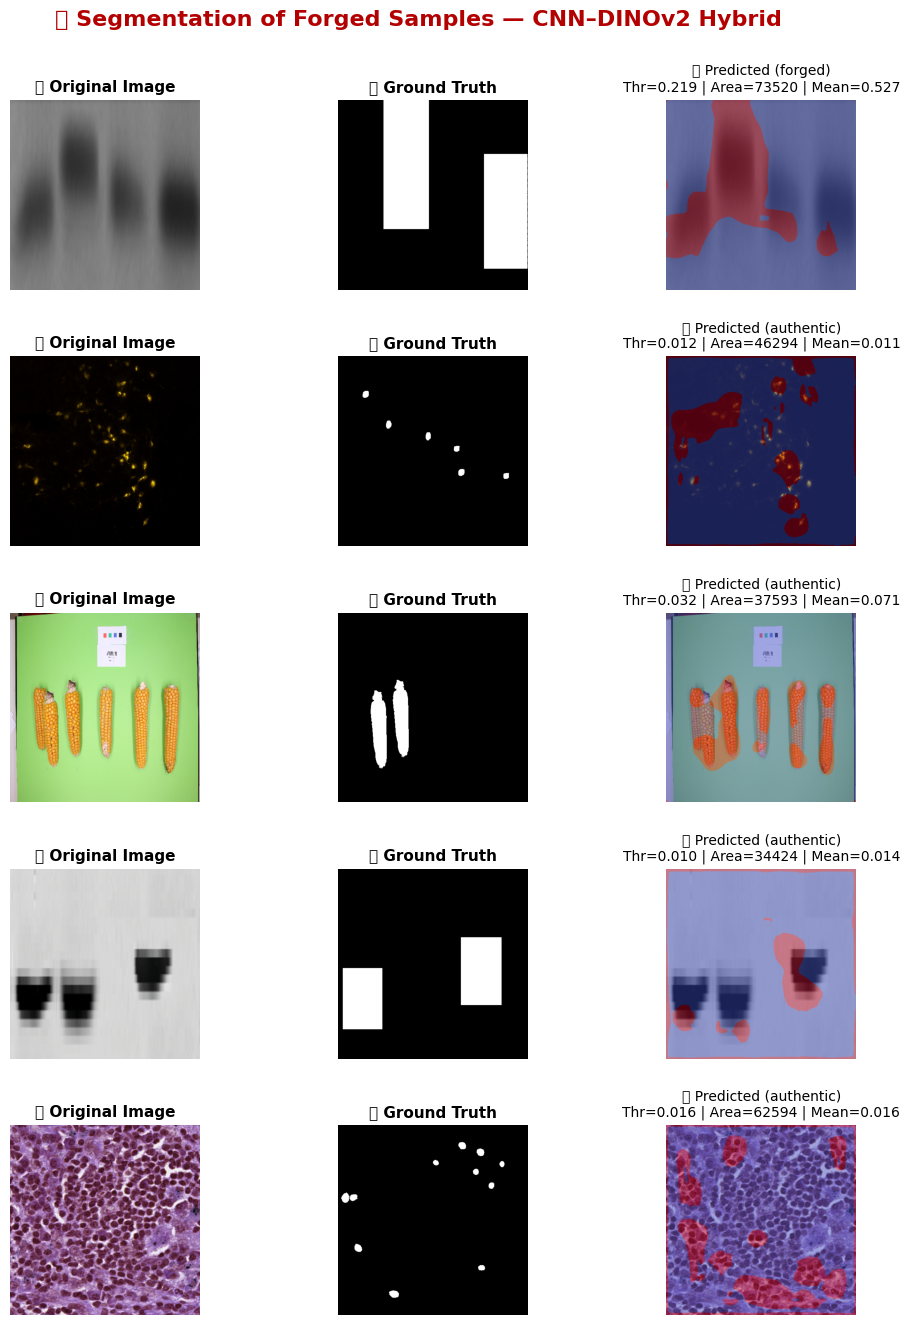

In [3]:
import torch, cv2, math, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Use global IMG_SIZE from cell 2 (518)

# 1️ Predict probability map (from model)
@torch.no_grad()
def predict_prob_map(pil):
    """Return DINOv2 segmentation probability map [0,1]."""
    img = pil.resize((IMG_SIZE, IMG_SIZE))
    x = torch.from_numpy(np.array(img, np.float32) / 255.).permute(2, 0, 1)[None].to(device)
    logits = model_seg.forward_seg(x)
    prob = torch.sigmoid(logits)[0, 0].cpu().numpy()
    return prob


# 2️ Post-processing consistent with pipeline_final
def adaptive_mask(prob, alpha_grad=0.35):
    """Adaptive enhancement + morphological refinement."""
    gx = cv2.Sobel(prob, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(prob, cv2.CV_32F, 0, 1, ksize=3)
    grad_mag = np.sqrt(gx**2 + gy**2)
    grad_norm = grad_mag / (grad_mag.max() + 1e-6)

    enhanced = (1 - alpha_grad) * prob + alpha_grad * grad_norm
    enhanced = cv2.GaussianBlur(enhanced, (3, 3), 0)

    thr = np.mean(enhanced) + 0.3 * np.std(enhanced)
    mask = (enhanced > thr).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    return mask, float(thr)


# 3️ Unified visualization pipeline (uses same filtering logic as pipeline_final)
def pipeline_visual(pil):
    if USE_TTA:
        prob = segment_prob_map_with_tta(pil)
    else:
        prob = predict_prob_map(pil)
    mask, thr = adaptive_mask(prob)
    area = int(mask.sum())
    mean_inside = float(prob[mask == 1].mean()) if area > 0 else 0.0

    # ✅ FIXED: Use same decision rule as pipeline_final for consistency
    if area < AREA_THR or mean_inside < MEAN_THR:
        label = "authentic"
    else:
        label = "forged"
    return label, mask, thr, area, mean_inside


# 4️ Visualization (for validation forged samples)
sample_forged = val_forg[:5]
n = len(sample_forged)
fig, axes = plt.subplots(n, 3, figsize=(12, n * 3))
if n == 1:
    axes = np.expand_dims(axes, axis=0)

for i, p in enumerate(sample_forged):
    pil = Image.open(p).convert("RGB")
    label, m_pred, thr, area, mean = pipeline_visual(pil)

    # Ground Truth mask
    m_gt = np.load(Path(MASK_DIR)/f"{Path(p).stem}.npy")
    if m_gt.ndim == 3: m_gt = np.max(m_gt, axis=0)
    m_gt = (m_gt > 0).astype(np.uint8)

    # Resize all for consistency
    img_disp = cv2.resize(np.array(pil), (IMG_SIZE, IMG_SIZE))
    gt_disp  = cv2.resize(m_gt, (IMG_SIZE, IMG_SIZE))
    pr_disp  = cv2.resize(m_pred, (IMG_SIZE, IMG_SIZE))

    # === Column 1: Original ===
    axes[i, 0].imshow(img_disp)
    axes[i, 0].set_title("🖼️ Original Image", fontsize=11, weight="bold")
    axes[i, 0].axis("off")

    # === Column 2: Ground Truth ===
    axes[i, 1].imshow(gt_disp, cmap="gray")
    axes[i, 1].set_title("✅ Ground Truth", fontsize=11, weight="bold")
    axes[i, 1].axis("off")

    # === Column 3: Predicted Mask ===
    axes[i, 2].imshow(img_disp)
    axes[i, 2].imshow(pr_disp, cmap="coolwarm", alpha=0.45)
    axes[i, 2].set_title(f"🔮 Predicted ({label})\nThr={thr:.3f} | Area={area} | Mean={mean:.3f}",
                         fontsize=10)
    axes[i, 2].axis("off")

plt.subplots_adjust(top=0.92, hspace=0.35)
fig.suptitle("🔍 Segmentation of Forged Samples — CNN–DINOv2 Hybrid", 
             fontsize=16, fontweight="bold", color="#b30000")

plt.show()

# 🟢 Visualization of Authentic Images (Hybrid DINOv2-based Detector)

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


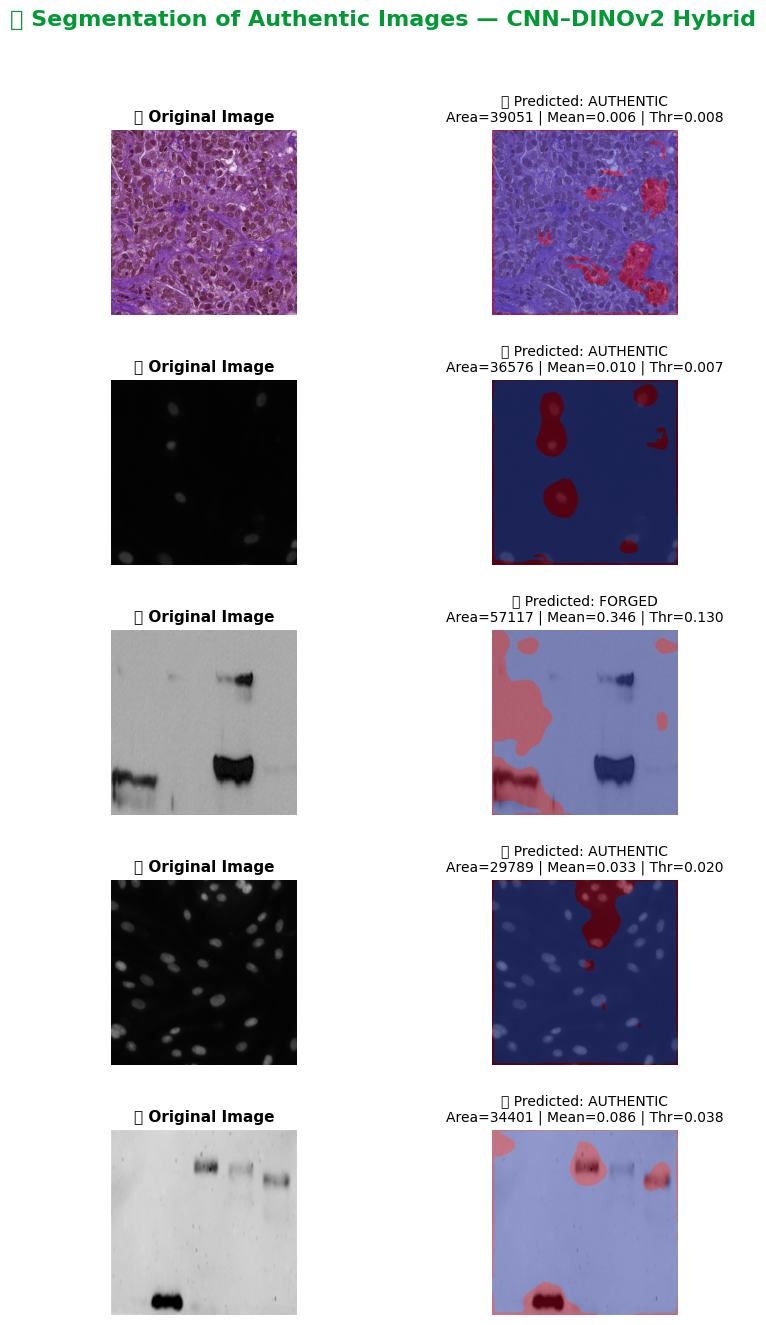

In [4]:
import matplotlib.pyplot as plt
import cv2, numpy as np
from pathlib import Path
from PIL import Image

# Select a few authentic examples
sample_auth = val_auth[:5]
n = len(sample_auth)

fig, axes = plt.subplots(n, 2, figsize=(9, n * 3))
if n == 1:
    axes = np.expand_dims(axes, axis=0)

for i, p in enumerate(sample_auth):
    pil = Image.open(p).convert("RGB")
    label, m_pred, thr, area, mean = pipeline_visual(pil)  # <-- version alignée avec ta nouvelle pipeline

    # Predicted mask (should be empty for authentic images)
    m_pred = (m_pred > 0).astype(np.uint8) if m_pred is not None else np.zeros((IMG_SIZE, IMG_SIZE))

    # Resize for consistent display
    img_disp = cv2.resize(np.array(pil), (IMG_SIZE, IMG_SIZE))
    pr_disp  = cv2.resize(m_pred, (IMG_SIZE, IMG_SIZE))

    # === Column 1: Original Image ===
    axes[i, 0].imshow(img_disp)
    axes[i, 0].set_title("🖼️ Original Image", fontsize=11, weight="bold")
    axes[i, 0].axis("off")

    # === Column 2: Predicted Mask ===
    axes[i, 1].imshow(img_disp)
    axes[i, 1].imshow(pr_disp, cmap="coolwarm", alpha=0.45)
    axes[i, 1].set_title(
        f"🟢 Predicted: {label.upper()}\nArea={area} | Mean={mean:.3f} | Thr={thr:.3f}",
        fontsize=10
    )
    axes[i, 1].axis("off")

    for j in range(2):
        axes[i, j].set_aspect("equal")

plt.subplots_adjust(top=0.90, hspace=0.35)
fig.suptitle("🟢 Segmentation of Authentic Images — CNN–DINOv2 Hybrid",
             fontsize=16, fontweight="bold", color="#009933")
plt.show()